# Spam Message Classifier using RoBERTa

## Introduction

Spam messages are a widespread issue across digital communication platforms, disrupting user experience and trust. This project focuses on building a spam message classifier using RoBERTa, a state-of-the-art transformer model for natural language understanding.

---

## Objectives

- Preprocess and clean SMS messages
- Fine-tune a pre-trained RoBERTa model
- Evaluate model performance using precision, recall, and F1-score
- Save and prepare the trained model for future integration

---

## Dataset: SMS Spam Collection

**Sources**:
1. **[SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)** from UCI Machine Learning Repository
2. **Discord Text Messages** — a manually collected dataset of real Discord messages containing both ham and spam samples. (This dataset was created to mitigate `<URL>` bias, as explained in a later section.)


**Preprocessing Steps**:
1. Label encoding (ham → 0, spam → 1)
2. Text cleaning and normalization with Discord-specific preprocessing
3. Train/validation/test split (70/15/15)
4. Tokenization with RoBERTa tokenizer
5. Dynamic padding and truncation

---

## Model: RoBERTa

We fine-tune a pre-trained `roberta-base` model using Hugging Face Transformers.

---

## Evaluation Metrics

We evaluate the model using standard classification metrics:

- **Precision**
- **Recall**
- **F1-score**
- **Accuracy**

### Acceptance Criteria

To ensure the model's reliability in real-world deployment, we define the following criterion:

> **The model will be considered acceptable if the F1-score for the `spam` class exceeds 0.95 on the test dataset.**

This threshold ensures the classifier effectively balances **precision** and **recall** for detecting spam, minimizing both false positives and false negatives.

---

## Output

The trained model, tokenizer, and preprocessing pipeline are saved in Hugging Face format, ready for inference or deployment.

You can find the trained model here:  
👉 **[roshana1s/spam-message-classifier on Hugging Face](https://huggingface.co/roshana1s/spam-message-classifier)**

---

## Integration with Amy (Discord Bot)

This spam classifier will be integrated into **Amy** — an intelligent Discord bot capable of:

- Detecting spam messages in real-time using this RoBERTa-based model
- Identifying toxic or harmful messages (via a **separate toxicity detection model**)

This project serves as the core backend for Amy’s moderation capabilities in Discord servers.

---

## Preparing the tools

In [1]:
!pip install transformers datasets optuna scikit-learn matplotlib seaborn pandas torch textattack -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# General libraries
import pandas as pd
import numpy as np
import random
import re

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Hugging Face Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Dataset
from datasets import Dataset

# PyTorch (used under the hood by transformers)
import torch
from torch import nn

# Optuna for hyperparameter tuning
import optuna

# textattack for augmentation
from textattack.augmentation import WordNetAugmenter

import sys
import os

In [4]:
def preprocess_text(text: str) -> str:
    text = re.sub(r"(https?:\/\/)?(www\.)?(discord\.(gg|io|me|li)|discordapp\.com\/invite)\/\S+", "<DISCORD_INVITE>", text)  # Discord invites first
    text = re.sub(r"(https?://\S+|www\.\S+)", "<URL>", text)  # URLs
    text = re.sub(r"<@!?\d+>", "<USER>", text)                # Mentions
    text = re.sub(r"<a?:\w+:\d+>", "<EMOJI>", text)           # Emojis
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Load Data

### Load UCI SMS Spam dataset

In [10]:
df = pd.read_csv("/content/data/sms_spam_uci.csv", encoding="latin1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df = df[['v1', 'v2']]  # Keep only label and message
df.columns = ['label', 'text']  # Rename for consistency
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# Convert labels to numbers
# Convert spam/ham to 1/0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df["label"].value_counts()

,count
label,
0,4825
1,747


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [16]:
df.isna().sum()

,0
label,0
text,0


In [17]:
# Make label to int
df["label"] = df["label"].astype(int)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Clean Data

In [18]:
df["text"] = df["text"].apply(preprocess_text)

In [19]:
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


### Handling `<URL>` Bias in Dataset

During initial training, the model became overconfident and labeled almost all messages containing `<URL>` as spam, even if some were legitimate ham. To mitigate this bias, I went through Discord servers and collected additional **real ham messages containing links**.  

This helps the model understand that URLs can appear in non-spam messages and improves generalization for real-world inference.

In [20]:
# Count messages with <URL> for each label
url_counts = df.groupby('label')['text'].apply(lambda x: x.str.contains('<URL>', regex=False).sum())

# Count total messages per label
total_counts = df['label'].value_counts().sort_index()

# Combine counts and calculate percentages
distribution = pd.DataFrame({
    'total': total_counts,
    'has_url': url_counts,
    'no_url': total_counts - url_counts,
})

distribution['has_url_pct'] = distribution['has_url'] / distribution['total'] * 100
distribution['no_url_pct'] = distribution['no_url'] / distribution['total'] * 100

distribution.index = ['ham', 'spam']  # optional, for readability
print(distribution)

      total  has_url  no_url  has_url_pct  no_url_pct
ham    4825        2    4823     0.041451   99.958549
spam    747      104     643    13.922356   86.077644


#### Load manually collected data

In [23]:
df2 = pd.read_csv("/content/data/url_dataset.csv")
df2.head()

,text,label
0,Whatever is in this course: https://zerotomast...,0
1,I found this video of someone building a real ...,0
2,https://levels.io/how-i-build-my-minimum-viabl...,0
3,Here is their patent list to kinda forcast wha...,0
4,"Hello everyone, could anyone tell me how to as...",0


In [24]:
# clean df2 data
df2 = df2[['label', 'text']]
df2["text"] = df2["text"].apply(preprocess_text)
df2.head()

,label,text
0,0,Whatever is in this course: <URL>
1,0,I found this video of someone building a real ...
2,0,<URL> This is a freaking great read Truly macb...
3,0,Here is their patent list to kinda forcast wha...
4,0,"Hello everyone, could anyone tell me how to as..."


In [25]:
# merge df2 with df
df = pd.concat([df, df2], ignore_index=True)
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5608,0,"Join our casual Valorant night, details here: ..."
5609,0,Download the latest Minecraft snapshot at <URL>
5610,0,Here's the leaderboard for last week's tournam...
5611,0,Register for the weekend gaming event here: <URL>


## Visualize data

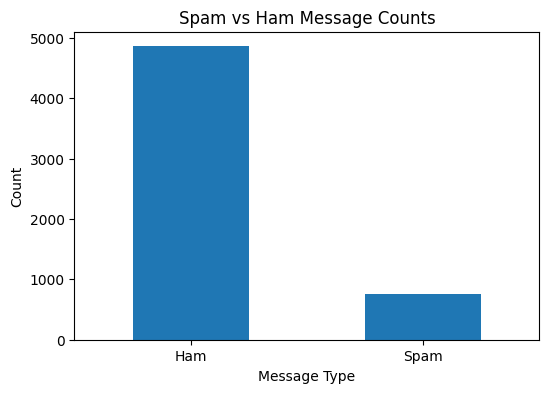

In [26]:
df["label"].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Spam vs Ham Message Counts")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

We can clearly see, there is class imbalance between `spam` and `ham`.

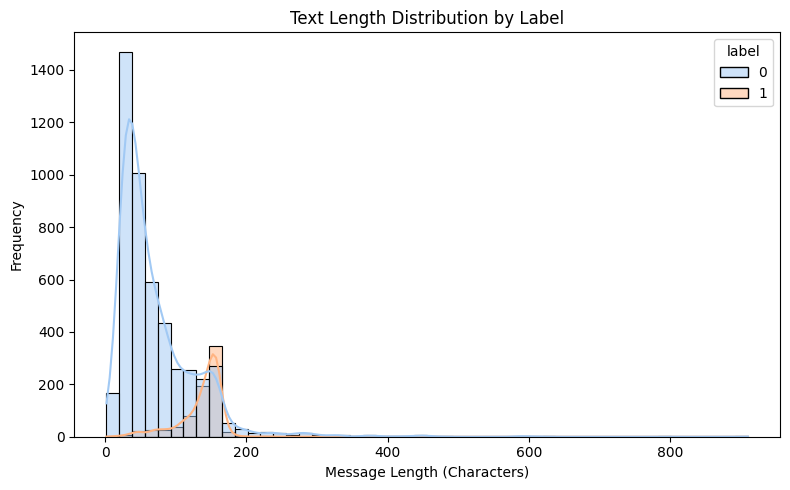

In [27]:
df["len"] = df["text"].apply(len)

# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="len", hue='label', bins=50, kde=True, palette='pastel')
plt.title("Text Length Distribution by Label")
plt.xlabel("Message Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

## Split Data

In [28]:
# Split data - preserve class distribution
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['label']  # Maintain class balance in splits
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

In [29]:
train_df.shape, val_df.shape, test_df.shape

((3929, 3), (842, 3), (842, 3))

In [30]:
train_df["label"].value_counts()

,count
label,
0,3403
1,526


In [31]:
val_df["label"].value_counts()

,count
label,
0,729
1,113


In [32]:
test_df["label"].value_counts()

,count
label,
0,729
1,113


In [33]:
train_df

,label,text,len
1064,0,"That's fine, I'll bitch at you about it later ...",50
3642,0,"Sorry, left phone upstairs. OK, might be hecti...",107
3630,0,Thank you princess! You are so sexy...,38
2124,0,Beautiful Truth against Gravity.. Read careful...,159
3268,0,Raviyog Peripherals bhayandar east,34
...,...,...,...
4473,1,Want explicit SEX in 30 secs? Ring 02073162414...,65
4714,0,S:)8 min to go for lunch:),26
805,0,I dled 3d its very imp,22
5154,0,"Like &lt;#&gt; , same question",30


We know that in this dataset, class imbalance is high. So, we need to have weighted trainer for that.

## Data Augmentation (only for ham messages with `<URL>` tag)

Let's check no. of ham messages in train set that has \<URL>.

In [34]:
# no. of ham messages in train set that has <URL>
train_df[train_df["label"] == 0]["text"].apply(lambda x: "<URL>" in x).sum()

np.int64(28)

Modify the ham messages that has \<URL> to make each message appear twice.

In [35]:
# Only select ham messages with <URL>
ham_with_url = train_df[(train_df['label'] == 0) & (train_df['text'].str.contains(r"<URL>", regex=True))]

# Initialize the augmenter
augmenter = WordNetAugmenter(pct_words_to_swap=0.1, transformations_per_example=2)

augmented_rows = []
for idx, row in ham_with_url.iterrows():
    augmented_texts = augmenter.augment(row['text'])
    for aug_text in augmented_texts:
        augmented_rows.append({
            "text": aug_text,
            "label": row['label'],
            "len": len(aug_text)
        })

# Convert augmented rows to DataFrame
aug_df = pd.DataFrame(augmented_rows)

# Add augmented data back to train_df
train_df = pd.concat([train_df, aug_df], ignore_index=True)

print(f"Original train set size: {len(train_df) - len(aug_df)}")
print(f"Augmented ham with URL count: {len(aug_df)}")
print(f"New train set size: {len(train_df)}")


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original train set size: 3929
Augmented ham with URL count: 56
New train set size: 3985


In [36]:
train_df

,label,text,len
0,0,"That's fine, I'll bitch at you about it later ...",50
1,0,"Sorry, left phone upstairs. OK, might be hecti...",107
2,0,Thank you princess! You are so sexy...,38
3,0,Beautiful Truth against Gravity.. Read careful...,159
4,0,Raviyog Peripherals bhayandar east,34
...,...,...,...
3980,0,Here is their patent list to kinda forcast wha...,126
3981,0,do you have a organization created in your Ope...,99
3982,0,do you have a organization created in your Ope...,93
3983,0,Here's the leaderboard for last week's tourney...,53


## Compute Class Weights

Let's compute class weights, then we can have a weighted loss function with computed class weights.

In [37]:
# Calculate weights based on TRAINING SET only
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

print(f"Class weights: {class_weights}")

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [0.57603354 3.78802281]


## Tokenization

In [38]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [39]:
def tokenize_function(batch):
    try:
        return tokenizer(
            batch['text'],
            truncation=True,
            max_length=128,
            padding=False,
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

In [40]:
# 1. Select only necessary columns
train_df = train_df[['label', 'text']]
val_df = val_df[['label', 'text']]
test_df = test_df[['label', 'text']]

# 2. Convert to Dataset objects (with proper validation)
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [41]:
# 3. Apply tokenization
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']  # Remove original text after tokenization
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# 4. Sort only training set by length
tokenized_train = tokenized_train.add_column(
    "length",
    [len(x) for x in tokenized_train["input_ids"]]
).sort("length")

# Final datasets
train_dataset = tokenized_train
val_dataset = tokenized_val
test_dataset = tokenized_test

Map:   0%|          | 0/3985 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]

Map:   0%|          | 0/842 [00:00<?, ? examples/s]

In [42]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 3985
})

In [43]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Pad to longest in batch
    max_length=128,  # Safety cap
    return_tensors="pt"
)

## Custom Trainer to use a weighted loss

In [44]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(kwargs['args'].device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=0.1)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Compute metrics function

In [45]:
def compute_metrics(eval_pred):
    """Robust metrics for imbalanced binary classification"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Essential metrics (all weighted by class support)
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
    }

    # Class-specific metrics
    metrics.update({
        # Spam class (label=1)
        'spam_precision': precision_score(labels, predictions, pos_label=1),
        'spam_recall': recall_score(labels, predictions, pos_label=1),
        'spam_f1': f1_score(labels, predictions, pos_label=1),

        # Ham class (label=0)
        'ham_precision': precision_score(labels, predictions, pos_label=0),
        'ham_recall': recall_score(labels, predictions, pos_label=0),
    })

    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    metrics.update({
        'confusion_matrix': {
            'true_negatives': int(tn),  # Correct hams
            'false_positives': int(fp), # Hams misclassified as spam (bad)
            'false_negatives': int(fn), # Spam missed (very bad)
            'true_positives': int(tp),  # Correct spam
        },
        'false_positive_rate': fp / (fp + tn),  # % of hams flagged as spam
        'false_negative_rate': fn / (fn + tp),  # % of spam missed
    })

    return metrics

## Optuna for Hyperparameter Tuning

In [46]:
# Define objective function
def objective(trial):
    # 1. Get parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.1, 0.3),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.2)
    }

    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "gradient_accumulation_steps": trial.suggest_int("grad_accum", 1, 4),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1)
    }

    # 2. Define the model
    model = RobertaForSequenceClassification.from_pretrained(
        'FacebookAI/roberta-base',
        num_labels=2,
        id2label={0: "ham", 1: "spam"},
        **model_params,
    )

    # 3. Create training arguments
    training_args = TrainingArguments(
        output_dir='/content/temp',
        eval_strategy="epoch",  # Eval after each epoch
        save_strategy="no",  # Do not save model checkpoints
        metric_for_best_model="eval_spam_f1",
        greater_is_better=True,
        load_best_model_at_end=False,  # No model saved, so can't load
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params,
    )

    # 4. Train with class weights
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    trainer.train()
    results = trainer.evaluate()
    return results['eval_spam_f1']

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, timeout=2.5*60*60)

best_params = study.best_params

[I 2025-11-03 19:39:08,904] A new study created in memory with name: no-name-0daee877-984c-4e11-bc8f-7c360461665d


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.415025,0.991686,0.991702,0.991723,0.991686,0.964912,0.973451,0.969163,0.995879,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 110}",0.005487,0.026549
2,0.501700,0.413981,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549
3,0.501700,0.415593,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549
4,0.439300,0.416086,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549


[I 2025-11-03 19:40:46,446] Trial 0 finished with value: 0.9734513274336283 and parameters: {'hidden_dropout': 0.17680303284729215, 'attn_dropout': 0.15964135028211648, 'learning_rate': 1.0248296910994211e-05, 'weight_decay': 0.060591739048152495, 'batch_size': 16, 'grad_accum': 1, 'epochs': 4, 'warmup': 0.05359656700061746}. Best is trial 0 with value: 0.9734513274336283.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.414603,0.990499,0.990534,0.990592,0.990499,0.956522,0.973451,0.964912,0.995873,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 110}",0.006859,0.026549
2,No log,0.415456,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
3,0.516200,0.418023,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398


[I 2025-11-03 19:42:09,147] Trial 1 finished with value: 0.9646017699115044 and parameters: {'hidden_dropout': 0.23305808930668084, 'attn_dropout': 0.13929042903674285, 'learning_rate': 2.5587365542186575e-05, 'weight_decay': 0.016739108516217117, 'batch_size': 8, 'grad_accum': 3, 'epochs': 3, 'warmup': 0.07314526067360722}. Best is trial 0 with value: 0.9734513274336283.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.423829,0.988124,0.988167,0.988234,0.988124,0.947826,0.964602,0.956140,0.994498,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 4, 'true_positives': 109}",0.008230,0.035398
2,No log,0.417628,0.989311,0.989408,0.989647,0.989311,0.940678,0.982301,0.961039,0.997238,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 2, 'true_positives': 111}",0.009602,0.017699
3,0.532200,0.419804,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398


[I 2025-11-03 19:43:31,998] Trial 2 finished with value: 0.9646017699115044 and parameters: {'hidden_dropout': 0.23461130416488962, 'attn_dropout': 0.11676493074734057, 'learning_rate': 1.0212137786575352e-05, 'weight_decay': 0.06056997848234465, 'batch_size': 8, 'grad_accum': 3, 'epochs': 3, 'warmup': 0.060732344770721244}. Best is trial 0 with value: 0.9734513274336283.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.423740,0.991686,0.991639,0.991646,0.991686,0.981818,0.955752,0.968610,0.993169,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 5, 'true_positives': 108}",0.002743,0.044248
2,No log,0.413400,0.994062,0.994028,0.994049,0.994062,0.990909,0.964602,0.977578,0.994536,0.998628,"{'true_negatives': 728, 'false_positives': 1, 'false_negatives': 4, 'true_positives': 109}",0.001372,0.035398


[I 2025-11-03 19:44:07,307] Trial 3 finished with value: 0.9775784753363229 and parameters: {'hidden_dropout': 0.20096302315789358, 'attn_dropout': 0.10873905905163447, 'learning_rate': 3.735869474185891e-05, 'weight_decay': 0.04335995859376986, 'batch_size': 32, 'grad_accum': 1, 'epochs': 2, 'warmup': 0.0535856173903449}. Best is trial 3 with value: 0.9775784753363229.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.413807,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398
2,No log,0.412865,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549
3,0.506400,0.413533,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398


[I 2025-11-03 19:45:29,542] Trial 4 finished with value: 0.9688888888888889 and parameters: {'hidden_dropout': 0.11358198347376335, 'attn_dropout': 0.18784414044396358, 'learning_rate': 1.4955507735516591e-05, 'weight_decay': 0.030232396980685285, 'batch_size': 8, 'grad_accum': 3, 'epochs': 3, 'warmup': 0.07632873855385966}. Best is trial 3 with value: 0.9775784753363229.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.401920,0.994062,0.994095,0.994180,0.994062,0.965517,0.991150,0.978166,0.998623,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 1, 'true_positives': 112}",0.005487,0.008850
2,No log,0.427739,0.941805,0.945978,0.959407,0.941805,0.697531,1.000000,0.821818,1.000000,0.932785,"{'true_negatives': 680, 'false_positives': 49, 'false_negatives': 0, 'true_positives': 113}",0.067215,0.000000
3,No log,0.398724,0.990499,0.990602,0.990908,0.990499,0.941176,0.991150,0.965517,0.998617,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 1, 'true_positives': 112}",0.009602,0.008850
4,No log,0.402027,0.994062,0.994073,0.994090,0.994062,0.973684,0.982301,0.977974,0.997253,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 2, 'true_positives': 111}",0.004115,0.017699


[I 2025-11-03 19:46:37,270] Trial 5 finished with value: 0.9779735682819384 and parameters: {'hidden_dropout': 0.10069482002001506, 'attn_dropout': 0.12460257350587067, 'learning_rate': 4.976184540342024e-05, 'weight_decay': 0.04490021845024478, 'batch_size': 16, 'grad_accum': 4, 'epochs': 4, 'warmup': 0.07622459860163384}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.423613,0.985748,0.985853,0.986047,0.985748,0.931624,0.964602,0.947826,0.994483,0.989026,"{'true_negatives': 721, 'false_positives': 8, 'false_negatives': 4, 'true_positives': 109}",0.010974,0.035398
2,0.502400,0.423590,0.989311,0.989331,0.989357,0.989311,0.956140,0.964602,0.960352,0.994505,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 4, 'true_positives': 109}",0.006859,0.035398


[I 2025-11-03 19:47:23,510] Trial 6 finished with value: 0.960352422907489 and parameters: {'hidden_dropout': 0.25964232801845066, 'attn_dropout': 0.16343931600957895, 'learning_rate': 1.6460041755049442e-05, 'weight_decay': 0.014550334328776893, 'batch_size': 16, 'grad_accum': 1, 'epochs': 2, 'warmup': 0.0797393924845012}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.415844,0.988124,0.988210,0.988388,0.988124,0.940171,0.973451,0.956522,0.995862,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 110}",0.009602,0.026549
2,No log,0.411179,0.988124,0.988210,0.988388,0.988124,0.940171,0.973451,0.956522,0.995862,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 110}",0.009602,0.026549


[I 2025-11-03 19:47:53,653] Trial 7 finished with value: 0.9565217391304348 and parameters: {'hidden_dropout': 0.10657301365777166, 'attn_dropout': 0.163235377103765, 'learning_rate': 1.330018418122702e-05, 'weight_decay': 0.09314143333011105, 'batch_size': 32, 'grad_accum': 3, 'epochs': 2, 'warmup': 0.06767122371911123}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.435209,0.984561,0.984701,0.984981,0.984561,0.923729,0.964602,0.943723,0.994475,0.987654,"{'true_negatives': 720, 'false_positives': 9, 'false_negatives': 4, 'true_positives': 109}",0.012346,0.035398
2,0.535000,0.432685,0.986936,0.987008,0.987131,0.986936,0.939655,0.964602,0.951965,0.994490,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 4, 'true_positives': 109}",0.009602,0.035398
3,0.535000,0.418849,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
4,0.452900,0.424456,0.989311,0.989331,0.989357,0.989311,0.956140,0.964602,0.960352,0.994505,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 4, 'true_positives': 109}",0.006859,0.035398
5,0.452900,0.424447,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549


[I 2025-11-03 19:49:46,511] Trial 8 finished with value: 0.9606986899563319 and parameters: {'hidden_dropout': 0.2913021219018903, 'attn_dropout': 0.17440099180381022, 'learning_rate': 1.2263876033822172e-05, 'weight_decay': 0.06145133948699375, 'batch_size': 16, 'grad_accum': 1, 'epochs': 5, 'warmup': 0.08257686704619058}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.426505,0.991686,0.991639,0.991646,0.991686,0.981818,0.955752,0.968610,0.993169,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 5, 'true_positives': 108}",0.002743,0.044248
2,0.525900,0.415425,0.988124,0.988210,0.988388,0.988124,0.940171,0.973451,0.956522,0.995862,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 110}",0.009602,0.026549
3,0.525900,0.410488,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549
4,0.469200,0.410126,0.991686,0.991702,0.991723,0.991686,0.964912,0.973451,0.969163,0.995879,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 110}",0.005487,0.026549


[I 2025-11-03 19:51:46,068] Trial 9 finished with value: 0.9691629955947136 and parameters: {'hidden_dropout': 0.12448288470641727, 'attn_dropout': 0.16235197062088028, 'learning_rate': 3.2807226022349836e-05, 'weight_decay': 0.04825377763407978, 'batch_size': 8, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.07115664216497126}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.421952,0.988124,0.988079,0.988057,0.988124,0.963964,0.946903,0.955357,0.991792,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 6, 'true_positives': 107}",0.005487,0.053097
2,No log,0.409024,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549
3,No log,0.413658,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398
4,No log,0.407428,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549
5,No log,0.404917,0.992874,0.992926,0.993071,0.992874,0.957265,0.991150,0.973913,0.998621,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 1, 'true_positives': 112}",0.006859,0.008850


[I 2025-11-03 19:53:10,415] Trial 10 finished with value: 0.9739130434782609 and parameters: {'hidden_dropout': 0.1568256866109657, 'attn_dropout': 0.1333381211579724, 'learning_rate': 4.9401400934818986e-05, 'weight_decay': 0.08524954953648961, 'batch_size': 16, 'grad_accum': 4, 'epochs': 5, 'warmup': 0.08877212857861604}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.417921,0.989311,0.989331,0.989357,0.989311,0.956140,0.964602,0.960352,0.994505,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 4, 'true_positives': 109}",0.006859,0.035398
2,No log,0.415767,0.986936,0.987008,0.987131,0.986936,0.939655,0.964602,0.951965,0.994490,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 4, 'true_positives': 109}",0.009602,0.035398
3,No log,0.415101,0.988124,0.988167,0.988234,0.988124,0.947826,0.964602,0.956140,0.994498,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 4, 'true_positives': 109}",0.008230,0.035398
4,No log,0.414309,0.988124,0.988210,0.988388,0.988124,0.940171,0.973451,0.956522,0.995862,0.990398,"{'true_negatives': 722, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 110}",0.009602,0.026549


[I 2025-11-03 19:54:07,675] Trial 11 finished with value: 0.9565217391304348 and parameters: {'hidden_dropout': 0.1895034117709254, 'attn_dropout': 0.10139491153322877, 'learning_rate': 4.7189558713546706e-05, 'weight_decay': 0.03732710001985959, 'batch_size': 32, 'grad_accum': 4, 'epochs': 4, 'warmup': 0.09909204207990258}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.409444,0.991686,0.991732,0.991830,0.991686,0.956897,0.982301,0.969432,0.997245,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 2, 'true_positives': 111}",0.006859,0.017699
2,No log,0.412456,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398


[I 2025-11-03 19:54:39,307] Trial 12 finished with value: 0.9646017699115044 and parameters: {'hidden_dropout': 0.1500118018030637, 'attn_dropout': 0.11816023954994445, 'learning_rate': 3.559673344878043e-05, 'weight_decay': 0.03927604807895213, 'batch_size': 32, 'grad_accum': 2, 'epochs': 2, 'warmup': 0.055222974164740764}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.444566,0.960808,0.962746,0.968936,0.960808,0.777778,0.991150,0.871595,0.998567,0.956104,"{'true_negatives': 697, 'false_positives': 32, 'false_negatives': 1, 'true_positives': 112}",0.043896,0.008850
2,No log,0.410179,0.990499,0.990568,0.990729,0.990499,0.948718,0.982301,0.965217,0.997241,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 2, 'true_positives': 111}",0.008230,0.017699
3,No log,0.415435,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398
4,No log,0.415572,0.991686,0.991702,0.991723,0.991686,0.964912,0.973451,0.969163,0.995879,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 110}",0.005487,0.026549


[I 2025-11-03 19:55:40,570] Trial 13 finished with value: 0.9691629955947136 and parameters: {'hidden_dropout': 0.21744522637541286, 'attn_dropout': 0.10205745602500366, 'learning_rate': 3.7022156363980295e-05, 'weight_decay': 0.07794793120863194, 'batch_size': 32, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.06327517195511204}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.416563,0.992874,0.992820,0.992863,0.992874,0.990826,0.955752,0.972973,0.993179,0.998628,"{'true_negatives': 728, 'false_positives': 1, 'false_negatives': 5, 'true_positives': 108}",0.001372,0.044248
2,No log,0.413833,0.980998,0.981398,0.982554,0.980998,0.888000,0.982301,0.932773,0.997211,0.980796,"{'true_negatives': 715, 'false_positives': 14, 'false_negatives': 2, 'true_positives': 111}",0.019204,0.017699
3,No log,0.412172,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549


[I 2025-11-03 19:56:31,769] Trial 14 finished with value: 0.9734513274336283 and parameters: {'hidden_dropout': 0.20357744735680502, 'attn_dropout': 0.12306751294302949, 'learning_rate': 2.6471176479988092e-05, 'weight_decay': 0.0035764926110544853, 'batch_size': 16, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.08809178883166198}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.412797,0.985748,0.985953,0.986507,0.985748,0.917355,0.982301,0.948718,0.997226,0.986283,"{'true_negatives': 719, 'false_positives': 10, 'false_negatives': 2, 'true_positives': 111}",0.013717,0.017699
2,No log,0.422893,0.985748,0.985853,0.986047,0.985748,0.931624,0.964602,0.947826,0.994483,0.989026,"{'true_negatives': 721, 'false_positives': 8, 'false_negatives': 4, 'true_positives': 109}",0.010974,0.035398
3,No log,0.412790,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398
4,No log,0.409594,0.994062,0.994073,0.994090,0.994062,0.973684,0.982301,0.977974,0.997253,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 2, 'true_positives': 111}",0.004115,0.017699
5,No log,0.414077,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398


[I 2025-11-03 19:57:48,074] Trial 15 finished with value: 0.9732142857142857 and parameters: {'hidden_dropout': 0.16501977796619394, 'attn_dropout': 0.14065610138826187, 'learning_rate': 4.2674193541063206e-05, 'weight_decay': 0.02390728248026044, 'batch_size': 32, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.06054565910898475}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.418847,0.990499,0.990426,0.990451,0.990499,0.981651,0.946903,0.963964,0.991814,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 6, 'true_positives': 107}",0.002743,0.053097
2,0.486300,0.419060,0.989311,0.989291,0.989277,0.989311,0.964286,0.955752,0.960000,0.993151,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 5, 'true_positives': 108}",0.005487,0.044248


[I 2025-11-03 19:58:34,100] Trial 16 finished with value: 0.96 and parameters: {'hidden_dropout': 0.1363133753568847, 'attn_dropout': 0.11396760425923673, 'learning_rate': 1.9477286158550672e-05, 'weight_decay': 0.04839252013364355, 'batch_size': 16, 'grad_accum': 1, 'epochs': 2, 'warmup': 0.05066533088147335}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.416455,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549
2,No log,0.413876,0.982185,0.982531,0.983519,0.982185,0.895161,0.982301,0.936709,0.997214,0.982167,"{'true_negatives': 716, 'false_positives': 13, 'false_negatives': 2, 'true_positives': 111}",0.017833,0.017699
3,No log,0.416950,0.985748,0.985953,0.986507,0.985748,0.917355,0.982301,0.948718,0.997226,0.986283,"{'true_negatives': 719, 'false_positives': 10, 'false_negatives': 2, 'true_positives': 111}",0.013717,0.017699


[I 2025-11-03 19:59:17,439] Trial 17 finished with value: 0.9487179487179487 and parameters: {'hidden_dropout': 0.2669965532382327, 'attn_dropout': 0.12954629313774774, 'learning_rate': 2.9808374263683833e-05, 'weight_decay': 0.07437991473323823, 'batch_size': 32, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.06647758325297187}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.417245,0.988124,0.988167,0.988234,0.988124,0.947826,0.964602,0.956140,0.994498,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 4, 'true_positives': 109}",0.008230,0.035398
2,No log,0.414331,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
3,No log,0.416087,0.992874,0.992820,0.992863,0.992874,0.990826,0.955752,0.972973,0.993179,0.998628,"{'true_negatives': 728, 'false_positives': 1, 'false_negatives': 5, 'true_positives': 108}",0.001372,0.044248
4,0.471200,0.407971,0.994062,0.994051,0.994045,0.994062,0.982143,0.973451,0.977778,0.995890,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 110}",0.002743,0.026549


[I 2025-11-03 20:00:32,628] Trial 18 finished with value: 0.9777777777777777 and parameters: {'hidden_dropout': 0.18918433157725764, 'attn_dropout': 0.10965897551220027, 'learning_rate': 4.059113569762896e-05, 'weight_decay': 0.038139744025373554, 'batch_size': 16, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.08771337699933901}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.430955,0.988124,0.988033,0.988038,0.988124,0.972477,0.938053,0.954955,0.990450,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 7, 'true_positives': 106}",0.004115,0.061947
2,No log,0.411328,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398
3,No log,0.409792,0.994062,0.994028,0.994049,0.994062,0.990909,0.964602,0.977578,0.994536,0.998628,"{'true_negatives': 728, 'false_positives': 1, 'false_negatives': 4, 'true_positives': 109}",0.001372,0.035398
4,No log,0.409359,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398


[I 2025-11-03 20:02:08,933] Trial 19 finished with value: 0.9732142857142857 and parameters: {'hidden_dropout': 0.10517348869575589, 'attn_dropout': 0.1500460498862321, 'learning_rate': 4.231666096013808e-05, 'weight_decay': 0.030861795379778893, 'batch_size': 16, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.09844457664603612}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.411181,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
2,No log,0.411240,0.991686,0.991702,0.991723,0.991686,0.964912,0.973451,0.969163,0.995879,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 110}",0.005487,0.026549
3,No log,0.406435,0.990499,0.990534,0.990592,0.990499,0.956522,0.973451,0.964912,0.995873,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 110}",0.006859,0.026549
4,0.468100,0.406195,0.990499,0.990534,0.990592,0.990499,0.956522,0.973451,0.964912,0.995873,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 110}",0.006859,0.026549
5,0.468100,0.409228,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549


[I 2025-11-03 20:04:08,990] Trial 20 finished with value: 0.9734513274336283 and parameters: {'hidden_dropout': 0.1365058480211338, 'attn_dropout': 0.14655372606732225, 'learning_rate': 2.1778874072782514e-05, 'weight_decay': 0.05655467463524282, 'batch_size': 16, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.091483105474013}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.453093,0.977435,0.977873,0.978942,0.977435,0.879032,0.964602,0.919831,0.994429,0.979424,"{'true_negatives': 714, 'false_positives': 15, 'false_negatives': 4, 'true_positives': 109}",0.020576,0.035398
2,0.511700,0.418044,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398
3,0.511700,0.411734,0.990499,0.990568,0.990729,0.990499,0.948718,0.982301,0.965217,0.997241,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 2, 'true_positives': 111}",0.008230,0.017699
4,0.443300,0.411824,0.992874,0.992900,0.992950,0.992874,0.965217,0.982301,0.973684,0.997249,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 2, 'true_positives': 111}",0.005487,0.017699


[I 2025-11-03 20:06:03,471] Trial 21 finished with value: 0.9736842105263158 and parameters: {'hidden_dropout': 0.19230261498284637, 'attn_dropout': 0.10984990827001664, 'learning_rate': 4.0338380626240554e-05, 'weight_decay': 0.04289230603374191, 'batch_size': 16, 'grad_accum': 1, 'epochs': 4, 'warmup': 0.08169592960808404}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.420451,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
2,No log,0.419042,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398
3,No log,0.418776,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398
4,0.472300,0.418883,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398


[I 2025-11-03 20:07:33,375] Trial 22 finished with value: 0.9688888888888889 and parameters: {'hidden_dropout': 0.2083043966495451, 'attn_dropout': 0.10794964288446066, 'learning_rate': 3.157667000119708e-05, 'weight_decay': 0.06866089815817694, 'batch_size': 16, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.09393834373635518}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.414766,0.990499,0.990499,0.990499,0.990499,0.964602,0.964602,0.964602,0.994513,0.994513,"{'true_negatives': 725, 'false_positives': 4, 'false_negatives': 4, 'true_positives': 109}",0.005487,0.035398
2,No log,0.415342,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549
3,No log,0.413546,0.991686,0.991671,0.991661,0.991686,0.973214,0.964602,0.968889,0.994521,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 109}",0.004115,0.035398


[I 2025-11-03 20:08:25,376] Trial 23 finished with value: 0.9688888888888889 and parameters: {'hidden_dropout': 0.17783889559267202, 'attn_dropout': 0.12698968082602854, 'learning_rate': 4.949759822319133e-05, 'weight_decay': 0.03325576470646203, 'batch_size': 32, 'grad_accum': 1, 'epochs': 3, 'warmup': 0.08577868275678201}. Best is trial 5 with value: 0.9779735682819384.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.431650,0.986936,0.986911,0.986893,0.986936,0.955357,0.946903,0.951111,0.991781,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 6, 'true_positives': 107}",0.006859,0.053097
2,No log,0.415044,0.990499,0.990534,0.990592,0.990499,0.956522,0.973451,0.964912,0.995873,0.993141,"{'true_negatives': 724, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 110}",0.006859,0.026549
3,No log,0.419829,0.990499,0.990463,0.990451,0.990499,0.972973,0.955752,0.964286,0.993160,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 5, 'true_positives': 108}",0.004115,0.044248
4,0.480600,0.415669,0.992874,0.992874,0.992874,0.992874,0.973451,0.973451,0.973451,0.995885,0.995885,"{'true_negatives': 726, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 110}",0.004115,0.026549


[I 2025-11-03 20:10:12,048] Trial 24 finished with value: 0.9734513274336283 and parameters: {'hidden_dropout': 0.22503046761924542, 'attn_dropout': 0.1233928442051335, 'learning_rate': 3.821088293198357e-05, 'weight_decay': 0.050956432805186504, 'batch_size': 16, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.07512763904911061}. Best is trial 5 with value: 0.9779735682819384.


In [48]:
best_params

{'hidden_dropout': 0.10069482002001506,
 'attn_dropout': 0.12460257350587067,
 'learning_rate': 4.976184540342024e-05,
 'weight_decay': 0.04490021845024478,
 'batch_size': 16,
 'grad_accum': 4,
 'epochs': 4,
 'warmup': 0.07622459860163384}

## Train the model with best hyperparameters

In [49]:
best_model_params = {
        "hidden_dropout_prob": best_params["hidden_dropout"],
        "attention_probs_dropout_prob": best_params["attn_dropout"]
}

best_training_params = {
        "learning_rate": best_params["learning_rate"],
        "weight_decay": best_params["weight_decay"],
        "per_device_train_batch_size": best_params["batch_size"],
        "gradient_accumulation_steps": best_params["grad_accum"],
        "num_train_epochs": best_params["epochs"],
        "warmup_ratio": best_params["warmup"]
}

In [50]:
model = RobertaForSequenceClassification.from_pretrained(
            'FacebookAI/roberta-base',
            num_labels=2,
            id2label={0: "ham", 1: "spam"},
            **best_model_params
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
training_args = TrainingArguments(
    output_dir='/content/results',
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_spam_f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    logging_steps=50,
    logging_dir='/content/logs',
    save_total_limit=2,
    **best_training_params,
)

In [52]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [53]:
# Start training (with class weights)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.570600,0.425143,0.992874,0.992792,0.992932,0.992874,1.000000,0.946903,0.972727,0.991837,1.000000,"{'true_negatives': 729, 'false_positives': 0, 'false_negatives': 6, 'true_positives': 107}",0.000000,0.053097
2,0.451300,0.420129,0.971496,0.972542,0.975911,0.971496,0.829630,0.991150,0.903226,0.998586,0.968450,"{'true_negatives': 706, 'false_positives': 23, 'false_negatives': 1, 'true_positives': 112}",0.031550,0.008850
3,0.437600,0.410056,0.989311,0.989370,0.989481,0.989311,0.948276,0.973451,0.960699,0.995868,0.991770,"{'true_negatives': 723, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 110}",0.008230,0.026549
4,0.425600,0.410781,0.992874,0.992847,0.992844,0.992874,0.981982,0.964602,0.973214,0.994528,0.997257,"{'true_negatives': 727, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 109}",0.002743,0.035398


TrainOutput(global_step=252, training_loss=0.46634737366721746, metrics={'train_runtime': 145.1678, 'train_samples_per_second': 109.804, 'train_steps_per_second': 1.736, 'total_flos': 491818798565340.0, 'train_loss': 0.46634737366721746, 'epoch': 4.0})

## Save the model

In [57]:
# Save the best model (based on eval_spam_f1)
trainer.save_model("best_spam_classifier_model")

## Model Evaluation

In [54]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)

In [55]:
def print_metrics(metrics):
    """Prints classification metrics in a human-readable format"""
    print("\nClassification Report")
    print("="*40)

    # Overall Performance
    print("\nOverall Metrics:")
    print(f"  Accuracy:           {metrics['eval_accuracy']:.2%}")
    print(f"  Weighted F1:        {metrics['eval_f1_weighted']:.4f}")
    print(f"  Weighted Precision: {metrics['eval_precision_weighted']:.4f}")
    print(f"  Weighted Recall:    {metrics['eval_recall_weighted']:.4f}")

    # Spam-Specific Performance
    print("\nSpam Detection:")
    print(f"  Precision: {metrics['eval_spam_precision']:.2%}")
    print(f"  Recall:    {metrics['eval_spam_recall']:.2%}")
    print(f"  F1:        {metrics['eval_spam_f1']:.4f}")
    print(f"  Miss Rate: {metrics['eval_false_negative_rate']:.2%}")

    # Ham-Specific Performance
    print("\nHam Detection:")
    print(f"  Precision: {metrics['eval_ham_precision']:.2%}")
    print(f"  Recall:    {metrics['eval_ham_recall']:.2%}")
    print(f"  FP Rate:   {metrics['eval_false_positive_rate']:.2%} (Ham flagged as spam)")

    # Confusion Matrix
    cm = metrics['eval_confusion_matrix']
    print("\nConfusion Matrix:")
    print(f"          | Predicted Ham | Predicted Spam")
    print(f"----------|---------------|---------------")
    print(f"Actual Ham| {cm['true_negatives']:^13} | {cm['false_positives']:^13}")
    print(f"Actual Spam| {cm['false_negatives']:^13} | {cm['true_positives']:^13}")

In [56]:
print_metrics(test_results)


Classification Report

Overall Metrics:
  Accuracy:           99.41%
  Weighted F1:        0.9941
  Weighted Precision: 0.9942
  Weighted Recall:    0.9941

Spam Detection:
  Precision: 96.55%
  Recall:    99.12%
  F1:        0.9782
  Miss Rate: 0.88%

Ham Detection:
  Precision: 99.86%
  Recall:    99.45%
  FP Rate:   0.55% (Ham flagged as spam)

Confusion Matrix:
          | Predicted Ham | Predicted Spam
----------|---------------|---------------
Actual Ham|      725      |       4      
Actual Spam|       1       |      112     


---

## Model Acceptance Summary

As evaluated on the test set:

- **F1-score for the `spam` class**: `0.9782`

This exceeds our predefined acceptance threshold of **0.95**, indicating that the model performs reliably in identifying spam messages with a strong balance between precision and recall.

> ✅ **Therefore, this model is accepted for deployment and will be integrated into Amy — our intelligent Discord bot.**


## Download the final model

In [58]:
# Zip the model directory
!zip -r /content/best_spam_classifier_model.zip /content/best_spam_classifier_model

  adding: content/best_spam_classifier_model/ (stored 0%)
  adding: content/best_spam_classifier_model/special_tokens_map.json (deflated 84%)
  adding: content/best_spam_classifier_model/tokenizer_config.json (deflated 76%)
  adding: content/best_spam_classifier_model/config.json (deflated 48%)
  adding: content/best_spam_classifier_model/model.safetensors (deflated 13%)
  adding: content/best_spam_classifier_model/vocab.json (deflated 68%)
  adding: content/best_spam_classifier_model/training_args.bin (deflated 53%)
  adding: content/best_spam_classifier_model/merges.txt (deflated 53%)


In [59]:
from google.colab import files

# Download the zipped model file
files.download('/content/best_spam_classifier_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>